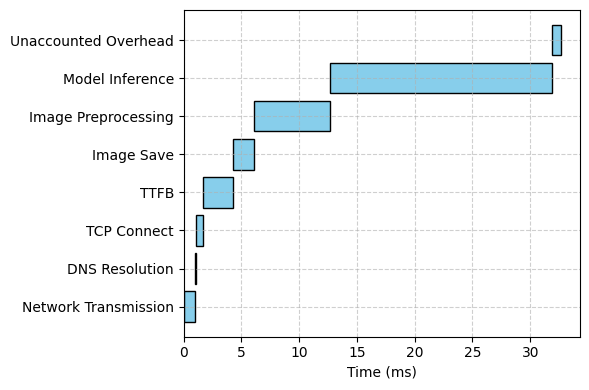

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

def analyze_request_latencies(df):
    """
    Analyzes the latencies for different stages of the request-processing lifecycle.
    """
    # Calculate latencies for each stage
    df["Network Transmission"] = df["network_time"] * 1000  # Convert to milliseconds
    df["DNS Resolution"] = df["dns_resolution"] * 1000  # Convert to milliseconds
    df["TCP Connect"] = df["tcp_connect"] * 1000  # Convert to milliseconds
    df["TTFB"] = df["ttfb"] * 1000  # Convert to milliseconds

    df["Image Save"] = (df["image_save_time"] - df["server_receive_time"]) * 1000
    df["Image Preprocessing"] = (df["image_preprocessed_time"] - df["image_save_time"]) * 1000
    df["Model Inference"] = (df["image_predicted_time"] - df["image_preprocessed_time"]) * 1000
    df["QoE Computation"] = (df["qoe_computed_time"] - df["image_predicted_time"]) * 1000
    df["Broker Handling"] = (df["broker_produced_time"] - df["qoe_computed_time"]) * 1000

    # Calculate total processing time
    df["Total"] = (
        df["Network Transmission"] +
        df["DNS Resolution"] +
        df["TCP Connect"] +
        df["TTFB"] +
        df["Image Save"] +
        df["Image Preprocessing"] +
        df["Model Inference"] +
        df["QoE Computation"] +
        df["Broker Handling"]
    )

    # Round-trip time (RTT) from client perspective
    df["RTT"] = (df["client_receive_time"] - df["client_send_time"]) * 1000

    # Other overheads that are unaccounted for in the processing breakdown
    df["Unaccounted Overhead"] = df["RTT"] - df["Total"]

    # Return a DataFrame with selected columns for better visualization
    return df[[
        "Network Transmission",
        "DNS Resolution",
        "TCP Connect",
        "TTFB",
        "Image Save",
        "Image Preprocessing",
        "Model Inference",
        "QoE Computation",
        "Broker Handling",
        "Total",
        "RTT",
        "Unaccounted Overhead"
    ]]

# Load and process the datasets
results_ckn = pd.read_csv("results_flask.csv")
results_ckn = analyze_request_latencies(results_ckn)
results_mean = results_ckn.mean().round(3).to_frame().T.drop(columns=["RTT", "Total"])

# Prepare Gantt chart data, filter out tasks with zero duration
task_durations = results_mean.iloc[0].to_dict()
df = pd.DataFrame.from_dict(task_durations, orient='index', columns=["Duration"])

# Filter out rows where Duration is zero
df = df[df['Duration'] > 0]

# Calculate start and end times for each task
df["Start"] = df["Duration"].cumsum() - df["Duration"]
df["End"] = df["Duration"].cumsum()

# Plot Gantt Chart
fig, ax = plt.subplots(figsize=(6, 4))

# Plot each task as a horizontal bar
for task, row in df.iterrows():
    ax.barh(task, row["Duration"], left=row["Start"], color="skyblue", edgecolor="black")

# Add labels and grid
ax.set_xlabel("Time (ms)")
ax.grid(True, linestyle="--", alpha=0.6)

# Display plot
plt.tight_layout()
plt.show()

In [8]:
results_mean

,Network Transmission,DNS Resolution,TCP Connect,TTFB,Image Save Latency,Image Preprocessing Latency,Model Inference Latency,QoE Computation Latency,Broker Handling Latency,Unaccounted Overhead
0,1.365,0.061,0.719,2.491,1.882,6.259,18.827,0.0,0.0,1.127


In [6]:
print(results_mean.T.to_latex(index=True, 
                             header=False, 
                             column_format='|l|c|', 
                             escape=False))

\begin{tabular}{|l|c|}
\toprule
\midrule
Network Transmission & 0.870000 \\
Image Save Latency & 1.858000 \\
Image Preprocessing Latency & 6.595000 \\
Model Inference Latency & 19.725000 \\
QoE Computation Latency & 0.000000 \\
Broker Handling Latency & 0.000000 \\
Unaccounted Overhead & 4.056000 \\
\bottomrule
\end{tabular}



,Image Preprocessing,Model Inference,Network Transmission,Image Save,QoE Computation,Broker Handling,Total,RTT,Other Overhead
0,5.948303,18.818769,0.72,0.487229,0.023362,1.057391,27.055055,32.638808,5.583753


,Image Preprocessing,Model Inference,Network Transmission,Image Save,QoE Computation,Broker Handling,Total,RTT,Other Overhead
0,7.926411,9.384312,0.72,1.16378,0.00879,1.709123,20.912417,28.088239,7.175822


<Figure size 1200x700 with 0 Axes>

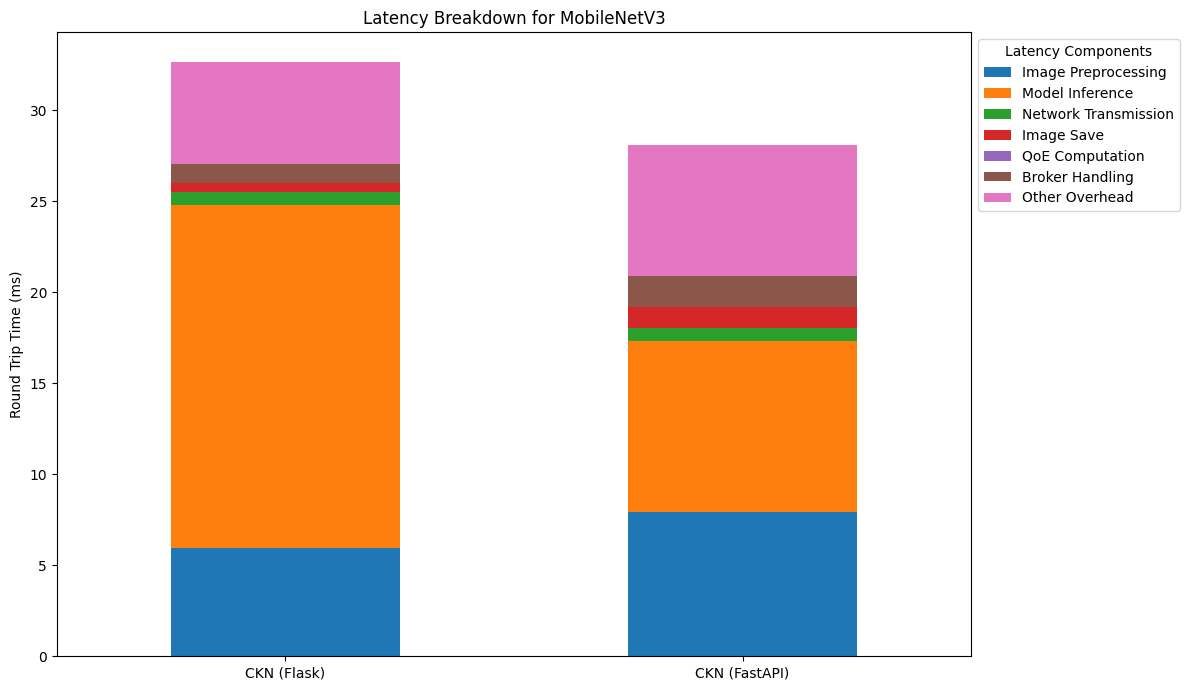

In [82]:
import pandas as pd
import matplotlib.pyplot as plt



def calculate_latencies_ckn(df):
    df["Network Transmission"] = 0.720
    df["Image Save"] = (df["image_save_at"] - df["server_receive_at"]) * 1000
    df["Image Preprocessing"] = (df["image_preprocessed_at"] - df["image_save_at"]) * 1000
    df["Model Inference"] = (df["image_predicted_at"] - df["image_preprocessed_at"]) * 1000
    df["QoE Computation"] = (df["qoe_computed_at"] - df["image_predicted_at"]) * 1000
    df["Broker Handling"] = (df["broker_produced_at"] - df["qoe_computed_at"]) * 1000
    df["Total"] = (
            df["Network Transmission"] +
            df["Image Save"] +
            df["Image Preprocessing"] +
            df["Model Inference"] +
            df["QoE Computation"] +
            df["Broker Handling"]
    )
    df["RTT"] = (df["client_receive_at"] - df["client_send_at"]) * 1000
    df["Other Overhead"] = df["RTT"] - df["Total"]

    return df[[
        "Image Preprocessing",
        "Model Inference",
        "Network Transmission",
        "Image Save",
        "QoE Computation",
        "Broker Handling",
        "Total",
        "RTT",
        "Other Overhead"
    ]]


results_ckn = pd.read_csv("results_flask_ckn.csv")
results_ckn = calculate_latencies_ckn(results_ckn)
results_ckn = results_ckn.mean().to_frame().T
display(results_ckn)
results_ckn = results_ckn.drop(columns=["RTT", "Total"])

results_fastapi_ckn = pd.read_csv("results_fast_ckn.csv")
results_fastapi_ckn = calculate_latencies_ckn(results_fastapi_ckn)
results_fastapi_ckn = results_fastapi_ckn.mean().to_frame().T
display(results_fastapi_ckn)
results_fastapi_ckn = results_fastapi_ckn.drop(columns=["RTT", "Total"])

# Combine the results into a single DataFrame
results_ckn[""] = "CKN (Flask)"
# results_rest[""] = "Flask (Without instrumentation)"
results_fastapi_ckn[""] = "CKN (FastAPI)"

combined_results = pd.concat([results_ckn, results_fastapi_ckn])
combined_results = combined_results.set_index("")

# Plotting the combined results
plt.figure(figsize=(12, 7))
ax = combined_results.plot(kind='bar', stacked=True, figsize=(12, 7))
plt.ylabel("Round Trip Time (ms)")
plt.title("Latency Breakdown for MobileNetV3")
plt.xticks(rotation=0)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Latency Components")
plt.tight_layout()

# Show the plot
plt.show()

,network_latency,save_latency,preprocess_latency,inference_latency,rtt
0,-41.105986,1.805067,13.996363,177.504778,198.049545
1,-43.675900,1.569271,7.701159,180.952311,192.418575
2,-43.195009,1.522541,7.690907,177.364588,189.313412
3,-43.865442,1.413822,6.989002,177.439928,188.074827
4,-43.907881,1.366854,6.944180,175.025463,185.477257
...,...,...,...,...,...
95,-43.826580,1.390457,6.300688,156.200409,166.182995
96,-43.841362,1.330853,6.231546,157.380104,167.344809
97,-43.720484,1.443148,6.788492,159.817696,170.530319
98,-43.599129,1.373053,6.266832,159.398794,169.882536


In [ ]:
resnet = pd.read_csv("/Users/neeleshkarthikeyan/d2i/ckn-edge-optimization/micro_benchmarking/results/resnet.csv")
resnet = calculate_latencies(resnet)
resnet
